# Notebook to run WireWalker Simulation with OceanParcels
1. Loads data from downloaded Glorys file to create netcdf files that OceanParcels can use 
2. Run Ocean Parcels
    - A. Set up WireWalker Array that we want to simulate, a bunch of parcels to be tracked by OceanParcels
    - B. Performs OceanParcels Simulation 
    - C. Look at output
4. Creates movie from OceanParcels output and Glorys SST 

## 1. Load Glorys data and create U and V files for OceanParcels

#### Load modules

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw
import cmocean.cm as cm
import datetime 
import pandas as pd

import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib import rc  

/var/folders/r2/q_k9q7fj4nb2fpczy_gzkq240000gq/T/ipykernel_70356/145864871.py:4: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


#### Load and extract data

In [3]:
# wishlist here: make this xarray capable 

#read Glorys data 
# right now it expects 0-6N, 145-135W ; but that probably does not matter. 
# this is Caique's original dataset 
# dat = nc.Dataset('cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i_1731177701169.nc')


# get time axis
time=dat['time'][:]

#create time in a way that we can handle later -> xarray might help with this 
day1=datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(time[0]))
timev=pd.date_range(day1,periods=time.size,freq='6h')

# this should not be necessary either 
lat=dat['latitude'][:]
lon=dat['longitude'][:]

RLON,RLAT=np.meshgrid(lon,lat)

# get the current information 
U=dat['uo'][:][:,:]
V=dat['vo'][:][:,:]

# change the depth axis from neg to pos or other way around
dep=-dat['depth'][:].data

# make a depth weighted average of the velocity field
# !!! THIS SHOULD BE INVESTIGATED
from scipy import integrate
U=integrate.trapezoid(U,dep,axis=1)/dep[-1]
V=integrate.trapezoid(V,dep,axis=1)/dep[-1]

# I am not quite sure what this is for, test this later
X = RLAT.copy()*np.nan
Y = RLAT.copy()*np.nan
for i in range(RLAT.shape[0]):
    X[i] = np.cumsum(np.append(0, sw.dist(RLAT[i],RLON[i], units='km')[0]))*1000
for i in range(RLAT.shape[1]):
    Y[:,i] = np.cumsum(np.append(0, sw.dist(RLAT[:,i],RLON[:,i], units='km')[0]))*1000


/var/folders/r2/q_k9q7fj4nb2fpczy_gzkq240000gq/T/ipykernel_70356/539795868.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timev=pd.date_range(day1,periods=time.size,freq='6H')


#### Write two current files U and V each 

In [6]:
# U
# open a netCDF file to write
ncout = nc.Dataset('Glorystraj2_0-760m_U.nc', 'w', format='NETCDF4')

# define axis size
ncout.createDimension('time_counter', U.shape[0])  # unlimited
ncout.createDimension('x', X[0].shape[0])
ncout.createDimension('y', Y[:,0].shape[0])
ncout.createDimension('depthu', 1)

from numpy import dtype

y = ncout.createVariable('y', dtype('float64').char, ('y',))
y.axis = 'y'
x = ncout.createVariable('x', dtype('float64').char, ('x',))
x.axis = 'x'
vozocrtx = ncout.createVariable('vozocrtx', dtype('float32').char, ('time_counter','depthu','y','x'))
depthu = ncout.createVariable('depthu', dtype('float32').char, ('depthu',))
depthu.axis = 'depthu'
nav_lon = ncout.createVariable('nav_lon', dtype('float32').char, ('y','x'))
time_counter = ncout.createVariable('time_counter', dtype('float64').char, ('time_counter',))
time_counter.axis = 'time_counter'
nav_lat = ncout.createVariable('nav_lat', dtype('float32').char, ('y','x'))

# copy axis from original dataset
t = np.arange(U.shape[0])*6*3600
time_counter[:] = t[:]

x[:] = X[0][:]
y[:] = Y[:,0][:]
nav_lat[:] = RLAT[:]
nav_lon[:] = RLON[:]
depthu[:] = np.array([0])[:]
vozocrtx[:] = U[:]

# close files
ncout.close()

# V
# open a netCDF file to write
ncout = nc.Dataset('Glorystraj2_0-760m_V.nc', 'w', format='NETCDF4')
from numpy import dtype

# define axis size
ncout.createDimension('time_counter', V.shape[0])  # unlimited
ncout.createDimension('x', X[0].shape[0])
ncout.createDimension('y', Y[:,0].shape[0])
ncout.createDimension('depthv', 1)

y = ncout.createVariable('y', dtype('float64').char, ('y',))
y.axis = 'y'
x = ncout.createVariable('x', dtype('float64').char, ('x',))
x.axis = 'x'
vomecrty = ncout.createVariable('vomecrty', dtype('float32').char, ('time_counter','depthv','y','x'))
depthv = ncout.createVariable('depthv', dtype('float32').char, ('depthv',))
depthv.axis = 'depthv'
nav_lon = ncout.createVariable('nav_lon', dtype('float32').char, ('y','x'))
time_counter = ncout.createVariable('time_counter', dtype('float64').char, ('time_counter',))
time_counter.axis = 'time_counter'
nav_lat = ncout.createVariable('nav_lat', dtype('float32').char, ('y','x'))

# copy axis from original dataset
t = np.arange(U.shape[0])*6*3600
time_counter[:] = t[:]

x[:] = X[0][:]
y[:] = Y[:,0][:]
nav_lat[:] = RLAT[:]
nav_lon[:] = RLON[:]
depthv[:] = np.array([0])[:]
vomecrty[:] = V[:]

# close files
ncout.close()

## 2. Run OceanParcels

#### Load modules

In [7]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter

#### Load prepared velocity files

In [9]:
fieldset = FieldSet.from_parcels('Glorystraj2_0-760m_')

### 2.A Set up arrays of particles we want to track

!!! THIS SHOULD BE DONE MORE EFFICIENTLY: Write a function

In [10]:
# put ww array 1
dist = 0.04  #Spacing between WWs
a = dist/2
lon1=-138 #Westernmost point
lat1=3.5      #Southernmost point

# making a triangle -> 3 wws
LO4 = np.array([lon1,lon1+2*a,lon1+a])
LA4 = np.array([lat1,lat1,lat1+np.sqrt(3)*a])

# put ww array 2
dist = 0.04  #Spacing between WWs
a = dist/2
lon1=-138 #Westernmost point
lat1=3      #Southernmost point

LO3 = np.array([lon1,lon1+2*a,lon1+a])
LA3 = np.array([lat1,lat1,lat1+np.sqrt(3)*a])

# put ww array 3
dist = 0.04  #Spacing between WWs
a = dist/2
lon1=-138 #Westernmost point
lat1=2.5      #Southernmost point

LO2 = np.array([lon1,lon1+2*a,lon1+a])
LA2 = np.array([lat1,lat1,lat1+np.sqrt(3)*a])


dist = 0.04  #Spacing between WWs
a = dist/2
lon1=-138 #Westernmost point
lat1=2      #Southernmost point

LO1 = np.array([lon1,lon1+2*a,lon1+a])
LA1 = np.array([lat1,lat1,lat1+np.sqrt(3)*a])


dist = 0.04  #Spacing between WWs
a = dist/2
lon0=-138 #Westernmost point
lat0=1.5      #Southernmost point

LO0 = np.array([lon0,lon0+2*a,lon0+a])
LA0 = np.array([lat0,lat0,lat0+np.sqrt(3)*a])

# concatenate the ww arrays
LO = np.concatenate([LO4,LO3,LO2,LO1,LO0])
LA = np.concatenate([LA4,LA3,LA2,LA1,LA0])

### 2.B Actually set up and run OceanParcels

In [11]:
#inserting the points in parcels
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=LO, # a vector of release longitudes 
                             lat=LA)    # a vector of release latitudes

output_file = pset.ParticleFile(name='Forward_dist4kmalleast_0-760m.zarr', outputdt=timedelta(hours=1)) 
# the file name and the time step of the outputs
pset.execute(AdvectionRK4,                 # the kernel (which defines how particles move)# the total length of the run
             dt=timedelta(hours=6),      # the timestep of the kernel
             runtime=timedelta(days=10),
             output_file=output_file)

INFO: Output files are stored in Forward_dist4kmalleast_0-760m.zarr.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 864000.0/864000.0 [00:03<00:00, 227149.65it/s]


### 2.C Look at the output file

Wishlist: 
- [ ] need to assign time axis to parcels: convert dtype='timedelta64[ns]' to something better

In [13]:
import xarray as xr

In [20]:
ds_particles = xr.open_dataset('Forward_dist4kmalleast_0-760m.zarr', engine='zarr')

In [29]:
ds_particles
# the trajectories are the parcels, what is obs?
# there is a time variable in dtype='timedelta64[ns]'

<xarray.Dataset> Size: 72kB
Dimensions:     (trajectory: 15, obs: 235)
Coordinates:
  * obs         (obs) int32 940B 0 1 2 3 4 5 6 7 ... 228 229 230 231 232 233 234
  * trajectory  (trajectory) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Data variables:
    lat         (trajectory, obs) float32 14kB 3.504 3.505 3.505 ... 1.238 1.236
    lon         (trajectory, obs) float32 14kB -138.0 -138.1 ... -141.0 -141.0
    time        (trajectory, obs) timedelta64[ns] 28kB 05:00:00 ... 9 days 23...
    z           (trajectory, obs) float32 14kB ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.1.0

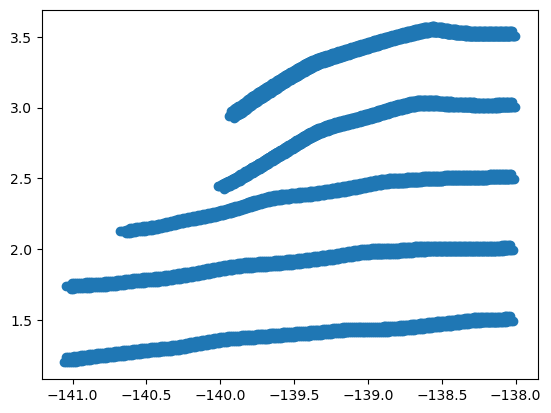

In [25]:
plt.scatter(ds_particles.lon, ds_particles.lat)

In [28]:
ds_particles.time.sel(trajectory=1)

<xarray.DataArray 'time' (obs: 235)> Size: 2kB
array([ 18000000000000,  21600000000000,  25200000000000, ..., 853200000000000,
       856800000000000, 860400000000000], dtype='timedelta64[ns]')
Coordinates:
  * obs         (obs) int32 940B 0 1 2 3 4 5 6 7 ... 228 229 230 231 232 233 234
    trajectory  int64 8B 1
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

## 3. Make Movie

#### Load modules
some of these are for sure duplicate and some might not be needed at all

In [30]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw
import cmocean.cm as cm
import datetime 
import pandas as pd

import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib import rc  

In [32]:
# I am not sure why we need u and v again now
dat = nc.Dataset('cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i_1731177701169.nc')

u=dat['uo'][:][:,0]
v=dat['vo'][:][:,0]

time=dat['time'][:]
day1=datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(time[0]))
timev=pd.date_range(day1,periods=time.size,freq='6h')

lat=dat['latitude'][:]
lon=dat['longitude'][:]

dat2 = nc.Dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_PT6H-i_1731178765930.nc')
temp=dat2['thetao'][:][:,0]



/var/folders/r2/q_k9q7fj4nb2fpczy_gzkq240000gq/T/ipykernel_70356/2553444706.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timev=pd.date_range(day1,periods=time.size,freq='6H')


In [33]:
# I am also not sure what this is for -> I thint it's calculating div and vorticity for a possible vorticity plot
idx=np.where((lat<8)&(lat>-1))[0]
lat=lat[idx]
u=u[:,idx,:]
v=v[:,idx,:]

LON,LAT=np.meshgrid(lon,lat)

[_,dx]=np.gradient(LON)
dx=dx*np.cos(np.pi*LAT/180)*111195

[dy,_]=np.gradient(LAT)
dy=dy*111195

[_,dudy,dudx]=np.gradient(u)
dudx=dudx/dx
dudy=dudy/dy

[_,dvdy,dvdx]=np.gradient(v)
dvdx=dvdx/dx
dvdy=dvdy/dy

zeta=dvdx-dudy

div = dudx+dvdy 

In [34]:
lonp=ds_particles['lon'][:,1::6]
latp=ds_particles['lat'][:,1::6]

#### Create the plots that underlie the movie

There is an index error here I need to figure out

<>:51: SyntaxWarning: invalid escape sequence '\z'
<>:51: SyntaxWarning: invalid escape sequence '\z'
/var/folders/r2/q_k9q7fj4nb2fpczy_gzkq240000gq/T/ipykernel_70356/265276118.py:51: SyntaxWarning: invalid escape sequence '\z'
  cbar.set_label('$\zeta$/$f$',weight='normal',fontsize=12)
/var/folders/r2/q_k9q7fj4nb2fpczy_gzkq240000gq/T/ipykernel_70356/265276118.py:51: SyntaxWarning: invalid escape sequence '\z'
  cbar.set_label('$\zeta$/$f$',weight='normal',fontsize=12)


IndexError: index 39 is out of bounds for axis 1 with size 39

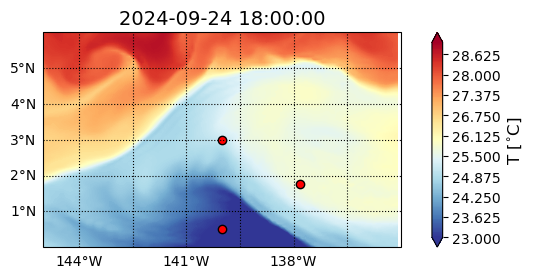

In [36]:
for i in range(20,u.shape[0],1):
    fig=plt.figure(figsize=(8,14))
    rc('font',size=10)    
    rc('font',weight='normal') 
    rc('xtick',labelsize=10)  
    rc('ytick',labelsize=10)
    grd = GridSpec(150,150)

    ax = fig.add_subplot(grd[0:30,:],projection=ccrs.PlateCarree())
    plt.title(str(timev[i]),weight='normal',fontsize=14)
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='0.9') 
    ax.add_feature(cfeature.COASTLINE, zorder=11) 
    ax.add_feature(cfeature.STATES,zorder=12,linewidth=0.2)
    ax.add_feature(cfeature.RIVERS, edgecolor='C0',linewidth=1,zorder=8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.8,color='k',alpha=1, linestyle='dotted',zorder=13)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'weight': 'normal'}
    gl.ylabel_style = {'size': 10, 'weight': 'normal'}
    # gl.xlocator = mticker.FixedLocator([-43,-42,-41,-40,-39,-38])
    # gl.ylocator = mticker.FixedLocator([-25,-24,-23,-22,-21])
    cf=plt.contourf(lon,lat,temp[i],np.arange(23,29.025,0.025),cmap='RdYlBu_r',extend='both')
    plt.scatter([-140,-137.83,-140],[0.5,1.75,3],color='red',edgecolor='k')
    cbar=plt.colorbar(cf)
    cbar.set_label(r'T [$^{\circ}$C]',weight='normal',fontsize=12)
    plt.grid()
    plt.xlim(-145,-135)
    plt.scatter(lonp[:,i-56],latp[:,i-56],color='yellow',edgecolor='k',s=10)

    ax = fig.add_subplot(grd[35:65,:],projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='0.9') 
    ax.add_feature(cfeature.COASTLINE, zorder=11) 
    ax.add_feature(cfeature.STATES,zorder=12,linewidth=0.2)
    ax.add_feature(cfeature.RIVERS, edgecolor='C0',linewidth=1,zorder=8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.8,color='k',alpha=1, linestyle='dotted',zorder=13)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'weight': 'normal'}
    gl.ylabel_style = {'size': 10, 'weight': 'normal'}
    # gl.xlocator = mticker.FixedLocator([-43,-42,-41,-40,-39,-38])
    # gl.ylocator = mticker.FixedLocator([-25,-24,-23,-22,-21])
    cf=plt.contourf(LON,LAT,zeta[i]/sw.f(3.5),np.arange(-3,3.25,0.25),cmap=cm.balance,extend='both')
    plt.scatter([-140,-137.83,-140],[0.5,1.75,3],color='red',edgecolor='k')
    cbar=plt.colorbar(cf)
    cbar.set_label('$\zeta$/$f$',weight='normal',fontsize=12)
    plt.grid()
    plt.xlim(-145,-135)
    plt.scatter(lonp[:,i-56],latp[:,i-56],color='yellow',edgecolor='k',s=10)

    plt.savefig('pngs/Forecast1_test_'+str(timev[i])+'.png',bbox_inches='tight',dpi=400)
    plt.close()

#### Load modules and create function needed to create the movie
currently I don't have cv2

In [2]:
import cv2
import os

def convert_images_to_video(input_folder, output_file, fps):
    # Get the list of image files in the input folder
    image_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.jpg') or f.endswith('.png')])

    # Read the first image to get its dimensions
    first_image = cv2.imread(os.path.join(input_folder, image_files[0]))
    height, width, _ = first_image.shape

    # Create a VideoWriter object to save the video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify the codec for the output video file
    video = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Iterate over each image and write it to the video
    for image_file in image_files:
        image_path = os.path.join(input_folder, image_file)
        frame = cv2.imread(image_path)
        video.write(frame)

    # Release the video writer and close the video file
    video.release()
    cv2.destroyAllWindows()

In [8]:
# sorted([f for f in os.listdir('./pngs/') if f.endswith('.jpg') or f.endswith('.png')])

In [4]:
%%time
# Provide the path to the input image folder, output video file, and desired FPS
input_folder = r'./pngs/'
output_file = r'./Forecast1.mp4'
fps = 3  # Frames per second

# Call the function to convert the images to video
convert_images_to_video(input_folder, output_file, fps)